## 1. Configure Spark

In [1]:
# import libraries for setting up spark and sql contexts
from pyspark import SparkContext, SparkConf
from pyspark.sql import DataFrameReader, SQLContext, DataFrameWriter

# import libraries for defining custom functions - udf indicates user defined function, type defines the type the function will return
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

import os


# define to postgres jdbc driver path as environment variable
sparkClassPath = os.getenv('SPARK_CLASSPATH', 
                           '/Users/user/Downloads/postgresql-42.2.14.jar')

In [2]:
# define configuration settings for Spark
conf = SparkConf()
conf.setAppName('application')
conf.set('spark.jars', f'file:{sparkClassPath}')
conf.set('spark.executor.extraClassPath', sparkClassPath)
conf.set('spark.driver.extraClassPath', sparkClassPath)

# define spark context - interface between client (notebook) and cluster manager
sc = SparkContext(conf=conf)
# define sql context - entry point for spark sql functionalkty - register dataframe as tables, which you can execute SQL on
sqlContext = SQLContext(sc)

# define postgres connection parameters
url = 'postgresql://localhost:5432/user'
properties = {'user': 'user', 'password': ''}

## 2. Sample Yelp review data

In [3]:
# define user defined function for create target column
set_target_values = udf(lambda x: (x > 3)*1, IntegerType())

In [4]:
# define sampling query
def get_sample(sample_size=100):
    query = """
            with reviews_1 as (
            select review_id, stars, text
            from yelp_reviews_filtered TABLESAMPLE BERNOULLI(75) 
            where stars = 1
            limit """ + str(sample_size) + """
            )
            , reviews_2 as (
                select review_id, stars, text
                from yelp_reviews_filtered TABLESAMPLE BERNOULLI(75)
                where stars = 2
                limit """ + str(sample_size) + """
            )
            , reviews_4 as (
                select review_id, stars, text
                from yelp_reviews_filtered TABLESAMPLE BERNOULLI(75)
                where stars = 4
                limit """ + str(sample_size) + """
            )
            , reviews_5 as (
                select review_id, stars, text
                from yelp_reviews_filtered TABLESAMPLE BERNOULLI(75)
                where stars = 5
                limit """ + str(sample_size) + """
            )

            select *
            from reviews_1
            union
            select *
            from reviews_2
            union
            select *
            from reviews_4
            union
            select *
            from reviews_5 
            """
    
    # read data from postgres into a dataframe
    df = DataFrameReader(sqlContext).jdbc(url=f'jdbc:{url}', 
                                      table=f'({query}) as sample', 
                                      properties=properties)
    
    df = df.withColumn('target', set_target_values(df.stars))
    
    return df

In [176]:
yelp = get_sample(50000)

In [177]:
yelp.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- target: integer (nullable = true)



In [178]:
yelp.show(5)

+--------------------+-----+--------------------+------+
|           review_id|stars|                text|target|
+--------------------+-----+--------------------+------+
|---WDP9kwKyVQiw9G...|    1|2nd time eating h...|     0|
|--1CHYhjfVIw_Nveh...|    4|happy that i foun...|     1|
|--1JMhPk6K9fZo4FO...|    2|had to stop in ju...|     0|
|--29SBl8OUdsRP0aS...|    1|worst! waited ove...|     0|
|--48T-86nuNb5uJb4...|    1|terrible.  very d...|     0|
+--------------------+-----+--------------------+------+
only showing top 5 rows



In [179]:
yelp.describe().show()

+-------+--------------------+------------------+-------------------------------------+------------------+
|summary|           review_id|             stars|                                 text|            target|
+-------+--------------------+------------------+-------------------------------------+------------------+
|  count|              200000|            200000|                               200000|            200000|
|   mean|                null|               3.0|                                 null|               0.5|
| stddev|                null|1.5811427829460865|                                 null|0.5000012500046852|
|    min|--096Ajil4RQtvH4s...|                 1|                 



if you haven'...|                 0|
|    max|zzylWZTq7LfXDXgJv...|                 5|服务员是真的傻逼，加个座位会挡住你...|                 1|
+-------+--------------------+------------------+-------------------------------------+------------------+



In [180]:
yelp.select('stars', 'target').show(5)

+-----+------+
|stars|target|
+-----+------+
|    1|     0|
|    1|     0|
|    1|     0|
|    4|     1|
|    2|     0|
+-----+------+
only showing top 5 rows



In [181]:
yelp.groupby('stars').count().sort('stars').show()

+-----+-----+
|stars|count|
+-----+-----+
|    1|50000|
|    2|50000|
|    4|50000|
|    5|50000|
+-----+-----+



In [182]:
# create temp view which SQL Context can use to run SQL queries on
yelp.createOrReplaceTempView('sample')

In [183]:
sqlContext.sql('select avg(stars) from sample').show()

+----------+
|avg(stars)|
+----------+
|       3.0|
+----------+



## 3a. Pre-process data for modelling - Manual steps

In [184]:
from pyspark.sql.functions import lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.sql.types import ArrayType, StringType
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [185]:
# set review test to lowercase
yelp = yelp.withColumn('text', lower(yelp.text))

In [186]:
yelp.select('text').show(10, truncate=50)

+--------------------------------------------------+
|                                              text|
+--------------------------------------------------+
|just not a good dining experience. how you can ...|
|very unimpressed by their pad thai.. one of the...|
|i just called this north york location at 416-4...|
|i made reservations on october 4, 2014 at 7:00p...|
|while visiting pittsburgh from ny had the good ...|
|really like this buffet! service was friendly. ...|
|we went in there to get a quick
bite. the waitr...|
|ehhh, pass on this one, highly disappointing! i...|
|this restaurant is a hot mess. we came here dur...|
|the waitress was not very nice.  my wife had fr...|
+--------------------------------------------------+
only showing top 10 rows



In [187]:
# remove punctuation
yelp = yelp.withColumn('text', regexp_replace(yelp.text, '[^\w\s\d]+', ''))

In [188]:
yelp.select('text').show(10, truncate=50)

+--------------------------------------------------+
|                                              text|
+--------------------------------------------------+
|red white and bleu salad was super yum and a gr...|
|2nd time eating here today1st time was great bu...|
|wow weve been missing out shouldve tried this a...|
|had to stop in just to see what the hype was ab...|
|worst waited over 25 minutes just for a 3 piece...|
|terrible  very disappointing we went for ramen ...|
|we came here for a breakfast at around 100 in t...|
|first time using this dominos location always u...|
|food was subpar prices too high along with high...|
|food not that tasty when i asked for extra cucu...|
+--------------------------------------------------+
only showing top 10 rows



In [189]:
# tokenizw review text
tokenizer = Tokenizer(inputCol='text', outputCol='word_tokens')

In [190]:
yelp_word_tokens = tokenizer.transform(yelp).select('review_id', 'stars', 'target', 'word_tokens')

In [191]:
yelp_word_tokens.show(5)

+--------------------+-----+------+--------------------+
|           review_id|stars|target|         word_tokens|
+--------------------+-----+------+--------------------+
|---j05qHS2X7FkXjj...|    5|     1|[november, 2018, ...|
|--096Ajil4RQtvH4s...|    1|     0|[i, ordered, whit...|
|--0XCA-1T8AecSI6t...|    1|     0|[slow, service, w...|
|--2DVbraypo43Yl1g...|    4|     1|[first, visit, an...|
|--3QLHdgTu4GCeBju...|    1|     0|[over, the, weeke...|
+--------------------+-----+------+--------------------+
only showing top 5 rows



In [192]:
# remove stop words
st_remover = StopWordsRemover(inputCol='word_tokens', outputCol='words_clean', stopWords=stopwords.words('english'))

In [193]:
yelp_words_clean = st_remover.transform(yelp_word_tokens).select('review_id', 'stars', 'target', 'words_clean')

In [194]:
yelp_words_clean.show(5)

+--------------------+-----+------+--------------------+
|           review_id|stars|target|         words_clean|
+--------------------+-----+------+--------------------+
|--0y7xOZPpiGD5d6v...|    1|     0|[unimpressed, pad...|
|--1-yyzQBuewSErAT...|    1|     0|[called, north, y...|
|--6jbEW2sVFSjTZI-...|    2|     0|[went, saturday, ...|
|--BFvQRQ0hMN_J5ij...|    1|     0|[drinks, ok, howe...|
|--CKRAtCONUvul6S3...|    5|     1|[good, local, fol...|
+--------------------+-----+------+--------------------+
only showing top 5 rows



In [195]:
# stem words
stemmer = PorterStemmer()
stemmer_udf = udf(lambda tokens: [stemmer.stem(w) for w in tokens], ArrayType(StringType()))

In [196]:
yelp_stemmed = yelp_words_clean.withColumn('words_clean', stemmer_udf(yelp_words_clean.words_clean))

In [197]:
yelp_stemmed.select('words_clean').show(10, truncate=50)

+--------------------------------------------------+
|                                       words_clean|
+--------------------------------------------------+
|[red, white, bleu, salad, super, yum, great, ad...|
|[one, absolut, favorit, restaur, usual, go, one...|
|[wow, weve, miss, shouldv, tri, lot, sooner, ny...|
|[happi, found, way, back, mani, year, , new, ow...|
|[stop, see, hype, came, away, shoulder, shrug, ...|
|[worst, wait, 25, minut, 3, piec, tender, combo...|
|[terribl, , disappoint, went, ramen, plain, tas...|
|[came, breakfast, around, 100, afternoon, bad, ...|
|[went, place, 112119, around, 1145am, put, spec...|
|[pasta, el, dent, , trust, even, italian, itali...|
+--------------------------------------------------+
only showing top 10 rows



In [198]:
# fitler short words
remove_empty_udf = udf(lambda tokens: [w for w in tokens if len(w) > 2], ArrayType(StringType()))

In [199]:
yelp_stemmed = yelp_stemmed.withColumn('words_clean', remove_empty_udf(yelp_stemmed.words_clean))

In [200]:
yelp_stemmed.select('words_clean').show(10, truncate=100)

+----------------------------------------------------------------------------------------------------+
|                                                                                         words_clean|
+----------------------------------------------------------------------------------------------------+
|[novemb, 2018, updat, one, still, terrif, healthi, fill, vegetarian, option, outstand, tandoori, ...|
|                                  [slow, servic, mediocr, food, look, cool, outsid, that, fun, stop]|
|[first, visit, disappoint, cant, tell, mani, time, walk, take, grant, ill, get, sometim, kind, at...|
|[weekend, ate, twice, first, experi, denni, night, hellth, cook, couldnt, seem, get, egg, fri, ha...|
|[friend, decid, give, place, shot, read, review, yelp, even, excit, see, make, long, stori, short...|
|[littl, press, time, decid, get, take, place, close, also, coupon, order, eye, got, quit, lot, fo...|
|[terribl, servic, boyfriend, wait, least, minut, server, notic, tri, get

In [201]:
from pyspark.ml.feature import NGram

In [202]:
# create ngrams = 2 col
ngrams = NGram(n=2, inputCol='words_clean', outputCol='ngrams_2')
yelp_ngrams = ngrams.transform(yelp_stemmed)

In [203]:
yelp_ngrams.show(5, truncate=50)

+----------------------+-----+------+--------------------------------------------------+--------------------------------------------------+
|             review_id|stars|target|                                       words_clean|                                          ngrams_2|
+----------------------+-----+------+--------------------------------------------------+--------------------------------------------------+
|---0hl58W-sjVTKi5LghGw|    4|     1|[ate, momo, momo, crawl, best, lot, decid, eat,...|[ate momo, momo momo, momo crawl, crawl best, b...|
|---D6-P4MpS86LYldBfX7w|    4|     1|[dont, know, place, lifesav, your, stay, mandal...|[dont know, know place, place lifesav, lifesav ...|
|--0FCNjk2NnZ2aUji5QYBg|    5|     1|[everi, time, come, food, perfect, one, favorit...|[everi time, time come, come food, food perfect...|
|--1-yyzQBuewSErATIDAEw|    1|     0|[call, north, york, locat, 4164461045, told, ca...|[call north, north york, york locat, locat 4164...|
|--2B5Wu-pXbNew_6bOF

In [204]:
# merge feature columns
merge_words_udf = udf(lambda col1, col2: col1 + col2, ArrayType(StringType()))

In [205]:
yelp_merged = yelp_ngrams.withColumn('features', merge_words_udf(yelp_ngrams.words_clean, yelp_ngrams.ngrams_2)).select('target', 'features')

In [206]:
# Create CountVectorizer
cv = CountVectorizer(minDF=5, vocabSize=100000, inputCol='features', outputCol='vectors')

In [207]:
cv_model = cv.fit(yelp_merged)
yelp_cv = cv_model.transform(yelp_merged)

In [208]:
yelp_cv.show(5, truncate=100)

+------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|target|                                                                                            features|                                                                                             vectors|
+------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|     1|[great, brisket, sandwich, claim, weird, station, hipster, bbq, lunch, spot, hallmark, store, car...|(100000,[8,90,102,201,354,435,790,835,839,1519,2770,5609,8813,67675],[1.0,1.0,1.0,1.0,1.0,1.0,1.0...|
|     0|[order, white, fri, hair, didnt, eat, also, got, philli, chicken, meat, dri, hoagi, roll, way, to...|(100000,[2,18,19,23,25,29,36,74,106,138,236,312

In [209]:
# number if words in the vocabulary - can only be run on the fit stage
sorted(map(str, cv_model.vocabulary))[:10]

['010',
 '025',
 '050',
 '075',
 '099',
 '100',
 '100 back',
 '100 beer',
 '100 better',
 '100 bill']

In [210]:
# fit IDF
idf = IDF(inputCol='vectors', outputCol='vectors_idf')

In [211]:
yelp_idf = idf.fit(yelp_cv).transform(yelp_cv.select('target', 'vectors')).select('target', 'vectors_idf')

In [212]:
yelp_idf.show(5, truncate=100)

+------+----------------------------------------------------------------------------------------------------+
|target|                                                                                         vectors_idf|
+------+----------------------------------------------------------------------------------------------------+
|     0|(100000,[2,4,8,19,22,23,25,27,34,36,55,83,86,96,101,129,150,178,214,216,345,426,500,746,753,950,1...|
|     1|(100000,[0,2,3,6,8,13,14,36,42,43,71,75,76,89,91,113,114,124,166,169,199,207,215,267,276,321,374,...|
|     1|(100000,[0,1,3,4,5,6,8,10,12,13,16,17,18,23,29,30,33,34,40,42,43,48,63,68,69,75,87,95,110,135,197...|
|     1|(100000,[6,8,10,34,36,68,69,70,98,109,177,194,216,217,274,357,366,416,500,524,543,879,921,1029,11...|
|     0|(100000,[16,39,40,66,122,248,257,486,563,646,3386,64271,66681],[1.8076804592809559,2.202563778914...|
+------+----------------------------------------------------------------------------------------------------+
only showi

## 3b. Pre-process data for modelling - Pipeline

I can't create a pipeline easily as to do this all my pre-processing stages need to have a fit/transnform step. I have two options for adding a pipeline:

- write a class for doing pre-processing for those steps which lack a tranform method
- re-write my code to allow for using methods which support .transform()

I don't want to do either right now. Instead I will continue with model creation

## 4. Model Creation

In [213]:
import numpy as np
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import recall_score, accuracy_score, classification_report, confusion_matrix
from time import time

In [214]:
# split data
data_train, data_test = yelp_idf.randomSplit([0.8, 0.2], seed=1)

In [215]:
# check sampling weights for target in training set
data_train.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1|80155|
|     0|79812|
+------+-----+



In [216]:
# check sampling weights for target in testing set
data_test.groupBy('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     1|19845|
|     0|20188|
+------+-----+



In [217]:
nb = NaiveBayes(featuresCol='vectors_idf',labelCol='target')
lr = LogisticRegression(featuresCol='vectors_idf',labelCol='target')


models = {
    'NB Bernoulli': (nb, 
                     ParamGridBuilder() \
                     .addGrid(nb.modelType, ['multinomial']) \
                     .build()),
    'Logistic Regression': (lr, 
                            ParamGridBuilder() \
                            .addGrid(lr.regParam, np.logspace(1, 5, 6)) \
                            .addGrid(lr.fitIntercept, [True, False]) \
                            .build())    
}

evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='target', metricName='areaUnderROC')

In [218]:
for key, value in models.items():
    print('Model: ', key)
    crossval = CrossValidator(estimator=nb, estimatorParamMaps=value[1], evaluator=evaluator, numFolds=5)
    
    t0 = time()
    model_fit = nb.fit(data_train)
    train_time = time() - t0
    print(("Train time: %0.3fs" % train_time))
#     print('Avg. Training Area Under ROC: ', np.round(statistics.mean(model_fit.avgMetrics),3))
    
    # find the best model parameters
#     java_model = model_fit.bestModel._java_obj

#     print('Best model parameters:', {param.name: java_model.getOrDefault(java_model.getParam(param.name)) for param in paramGrid[0]})
    
    # get predictions for test set
    pred_test = model_fit.transform(data_test)
    test_target = [int(row['target']) for row in pred_test.collect()]
    test_pred = [int(row['prediction']) for row in pred_test.collect()]

    print('Test Area Under ROC: ', np.round(evaluator.evaluate(pred_test),3))
    print("Test accuracy : ", np.round(accuracy_score(test_target, test_pred),3))
    print("Test recall (class 0): ", np.round(recall_score(test_target, test_pred, average='binary', pos_label=0),3)) # average='macro'

    print('\nconfusion matrix: ')
    print(confusion_matrix(test_target, test_pred))
    print('\n')
    print(classification_report(test_target, test_pred))
    print('-' * 60)
    

Model:  NB Bernoulli
Train time: 486.163s
Test Area Under ROC:  0.924
Test accuracy :  0.92
Test recall (class 0):  0.905

confusion matrix: 
[[18261  1927]
 [ 1256 18589]]


              precision    recall  f1-score   support

           0       0.94      0.90      0.92     20188
           1       0.91      0.94      0.92     19845

    accuracy                           0.92     40033
   macro avg       0.92      0.92      0.92     40033
weighted avg       0.92      0.92      0.92     40033

------------------------------------------------------------
Model:  Logistic Regression
Train time: 529.331s
Test Area Under ROC:  0.924
Test accuracy :  0.92
Test recall (class 0):  0.9

confusion matrix: 
[[18174  2014]
 [ 1176 18669]]


              precision    recall  f1-score   support

           0       0.94      0.90      0.92     20188
           1       0.90      0.94      0.92     19845

    accuracy                           0.92     40033
   macro avg       0.92      0.92      

In [ ]:
# stop spark cluster
sc.stop()

---

In [93]:
model_summary = model_fit.summary

AttributeError: 'CrossValidatorModel' object has no attribute 'summary'

In [49]:
model_summary.areaUnderROC

0.8713499999999997

In [50]:
model_summary.predictions.select('target', 'probability', 'prediction').show(10, truncate=False)

+------+-------------------------------------------+----------+
|target|probability                                |prediction|
+------+-------------------------------------------+----------+
|0.0   |[0.8295681887795381,0.1704318112204619]    |0.0       |
|1.0   |[1.1838908066037959E-8,0.9999999881610918] |1.0       |
|1.0   |[1.0,4.060738456944009E-23]                |0.0       |
|0.0   |[1.0,7.823101973685385E-19]                |0.0       |
|1.0   |[1.2721337849774822E-10,0.9999999998727866]|1.0       |
|0.0   |[1.0,2.15743994651109E-19]                 |0.0       |
|1.0   |[4.959395577289689E-6,0.9999950406044228]  |1.0       |
|1.0   |[0.9999999999999989,1.1632385162579999E-15]|0.0       |
|1.0   |[0.019733870395414795,0.9802661296045853]  |1.0       |
|1.0   |[7.738453331668664E-11,0.9999999999226155] |1.0       |
+------+-------------------------------------------+----------+
only showing top 10 rows



In [51]:
import matplotlib.pyplot as plt

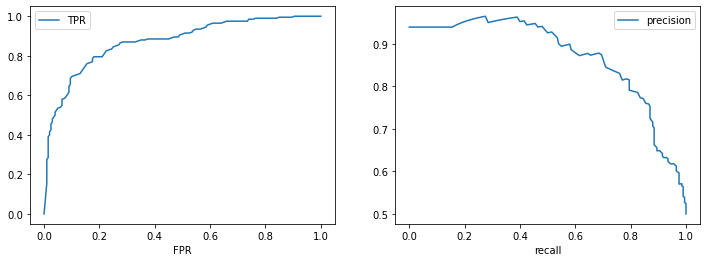

In [52]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
model_summary.roc.toPandas().plot(x='FPR', y='TPR', ax=ax[0])
model_summary.pr.toPandas().plot(x='recall', y='precision', ax=ax[1])
plt.show()